<a href="https://colab.research.google.com/github/NANTHIESH/CSE110-Problem-Solving-and-Programming-in-C/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

Text Classification is relevant in many industrial settings, for example:
- spam detection
- sentiment analysis
- hate speech detection

There are also several theoretical NLP problems that are framed as classification, such as Natural Language Inference.

For this practical work, we will study the detection of automatically generated text (more specifically, automatically generated research papers), based on the work of [Liyanage et al. 2022 "A Benchmark Corpus for the Detection of Automatically Generated Text in Academic Publications"](https://aclanthology.org/2022.lrec-1.501)

> Automatic text generation based on neural language models has achieved performance levels that make the generated text almost indistinguishable from those written by humans. Despite the value that text generation can have in various applications, it can also be employed for malicious tasks. The diffusion of such practices represent a threat to the quality of academic publishing. To address these problems, we propose in this paper two datasets comprised of artificially generated research content: a completely synthetic dataset and a partial text substitution dataset. In the first case, the content is completely generated by the GPT-2 model after a short prompt extracted from original papers. The partial or hybrid dataset is created by replacing several sentences of abstracts with sentences that are generated by the Arxiv-NLP model. We evaluate the quality of the datasets comparing the generated texts to aligned original texts using fluency metrics such as BLEU and ROUGE. The more natural the artificial texts seem, the more difficult they are to detect and the better is the benchmark. We also evaluate the difficulty of the task of distinguishing original from generated text by using state-of-the-art classification models.

# Imports

Note: you're not allowed to use any other libraries than these

In [37]:
from pathlib import Path
import re
from collections import Counter
import matplotlib.pyplot as plt

# N.B. we use torch for consistency with the rest of the class
# but will not use GPUs nor autograd here,
# everything could be done in numpy
import torch
import numpy as np

# Data
We will use the Hybrid subset of Liyanage et al. in which some sentences of human-written abstracts where replaced by automatically-generated text.

There are no train-test split provided in the paper but we keep 80% to train and 20% to test, following Liyanage et al.

In [2]:
!wget https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip

!unzip main.zip

--2025-09-29 09:13:08--  https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main [following]
--2025-09-29 09:13:08--  https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819461 (800K) [application/zip]
Saving to: ‘main.zip’

main.zip            100%[===================>] 800.25K  --.-KB/s    in 0.1s    

2025-09-29 09:13:08 (5.21 MB/s) - ‘main.zip’ saved [819461/819461]

Archive:  main.zip
ab034465f857a93212a894fe598edb749345b6ff
   creating: GeneratedTextDetection-main/
  infl

In [3]:
root = Path("GeneratedTextDetection-main/Dataset/Hybrid_AbstractDataset")

train_texts, train_labels, test_texts, test_labels = [], [], [], []
for path in root.glob("*.txt"):
    with open(path, 'rt') as file:
        text = file.read()
    label = int(path.name.endswith("generatedAbstract.txt"))
    doc_id = int(path.name.split("_")[0].split(".")[-1])
    if doc_id < 10522:
        test_texts.append(text)
        test_labels.append(label)
    else:
        train_texts.append(text)
        train_labels.append(label)

In [4]:
train_labels, test_labels = torch.tensor(train_labels), torch.tensor(test_labels)

In [5]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(160, 160, 40, 40)

In [6]:
train_texts[0]

'\ufeffOptimization problems are crucial in artificial in- telligence. Optimization algorithms are generally used to adjust the performance of artificial intelligence models to minimize the error of mapping inputs to outputs. Current evaluation methods on optimization algorithms generally consider the performance in terms of quality. However, not all optimization algorithms for all test cases are evaluated equal from quality, the computation time should be also considered for optimization tasks. In this paper, we investigate the quality and computation time of optimization algorithms in optimization problems, instead of the one-for-all evaluation of quality. We select the well-known optimization algorithms (Bayesian optimization and evolutionary algorithms) and evaluate them on the benchmark test functions in terms of quality and computation time. The results show that BO is suitable to be applied in the optimization tasks that are needed to obtain desired quality in the limited functi

In [7]:
train_labels[0]

tensor(0)

In [8]:
train_texts[10]

'\ufeffActive inference is a state-of-the-art framework for modelling the brain that explains a wide range of mechanisms such as habit for- mation, dopaminergic discharge and curiosity. However, recent im- plementations suffer from an exponential (space and time) com- plexity class when computing the prior over all the possible policies up to the time horizon. Fountas et al. (2020) used Monte Carlo tree search to address this problem, leading to very good results in two different tasks. Additionally, Champion et al. (2021a) pro- posed a tree search approach based on structure learning. This was enabled by the development of a variational message passing ap- proach to active inference (Champion et al., 2021b), which enables compositional construction of Bayesian networks for active infer- ence. However, this message passing tree search approach, which we call branching-time active inference (BTAI), has never been tested empirically. In this paper, we present an experimental study of the

In [9]:
train_labels[10]

tensor(0)

# Tokenization


Unsing `re`, tokenize the text in a `List[str]` to keep only words, no punctuation or space. We will also preprocess the text to make it lowercase, so our model is *case-insensitive*

In [38]:
class Tokenizer:
    def __init__(self, V = 1000):
        self.vocabulary = {}
        self.V = V

    def tokenize(self, text):
        tokens = re.findall(r"\b\w+\b", text.lower())
        return tokens
        raise NotImplementedError()

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.vocabulary[token] for token in tokens if token in self.vocabulary]
        raise NotImplementedError()

    def bow_encode(self, texts):
        matrix = np.zeros((len(texts), self.V), dtype=int)
        for i, text in enumerate(texts):
            token_ids = self.encode(text)
            for token_id in token_ids:
                matrix[i, token_id] += 1
        return matrix
        raise NotImplementedError()

    def set_vocab(self, train_texts):
      occurrences = Counter()
      for text in train_texts:
        tokens = self.tokenize(text)
        occurrences.update(tokens)

        # Keep only the V most common words
        most_common = occurrences.most_common(self.V)
        self.vocabulary = {word: idx for idx, (word, _) in enumerate(most_common)}
        self.inv_vocab = {idx: word for word, idx in self.vocabulary.items()}
      return occurrences

In [39]:
tokenizer = Tokenizer()

In [40]:
tokenizer.tokenize(train_texts[0])

['optimization',
 'problems',
 'are',
 'crucial',
 'in',
 'artificial',
 'in',
 'telligence',
 'optimization',
 'algorithms',
 'are',
 'generally',
 'used',
 'to',
 'adjust',
 'the',
 'performance',
 'of',
 'artificial',
 'intelligence',
 'models',
 'to',
 'minimize',
 'the',
 'error',
 'of',
 'mapping',
 'inputs',
 'to',
 'outputs',
 'current',
 'evaluation',
 'methods',
 'on',
 'optimization',
 'algorithms',
 'generally',
 'consider',
 'the',
 'performance',
 'in',
 'terms',
 'of',
 'quality',
 'however',
 'not',
 'all',
 'optimization',
 'algorithms',
 'for',
 'all',
 'test',
 'cases',
 'are',
 'evaluated',
 'equal',
 'from',
 'quality',
 'the',
 'computation',
 'time',
 'should',
 'be',
 'also',
 'considered',
 'for',
 'optimization',
 'tasks',
 'in',
 'this',
 'paper',
 'we',
 'investigate',
 'the',
 'quality',
 'and',
 'computation',
 'time',
 'of',
 'optimization',
 'algorithms',
 'in',
 'optimization',
 'problems',
 'instead',
 'of',
 'the',
 'one',
 'for',
 'all',
 'evaluation

### Vocabulary



Using `collections.Counter`, construct the vocabulary and keep only the $V$ most frequent words. Let's set $V=1000$ to start

Then use this vocabulary to tensorize examples, assigning integer identifiers to words (from $0$ for the most frequent to $V-1$)

Then, tensorize all examples in a matrix of dimension $V$

In [41]:
tokenizer = Tokenizer(V = 1000)
occurrences = tokenizer.set_vocab(train_texts)

In [42]:
train_bow = tokenizer.bow_encode(train_texts)

In [43]:
test_bow = tokenizer.bow_encode(test_texts)

## Zipf's Law

![image.png](https://paullerner.github.io/aivancity_nlp/_static/zipf.png)



In [44]:
occurrences.most_common(10)

[('the', 1578),
 ('of', 1014),
 ('to', 812),
 ('a', 740),
 ('and', 669),
 ('in', 578),
 ('that', 370),
 ('we', 360),
 ('is', 347),
 ('for', 315)]

In [45]:
occurrences.most_common()[-10:]

[('partly', 1),
 ('customize', 1),
 ('recognize', 1),
 ('lesions', 1),
 ('adapted', 1),
 ('texts', 1),
 ('publications', 1),
 ('articles', 1),
 ('reiter', 1),
 ('theories', 1)]

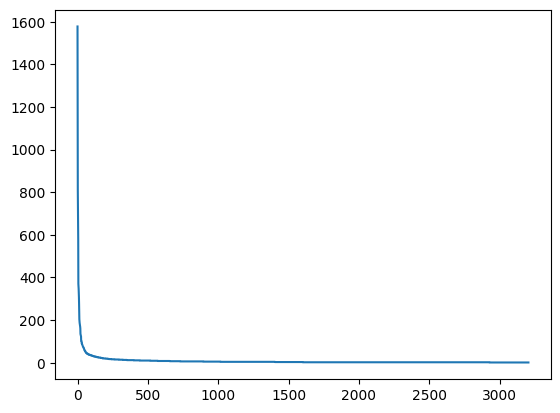

In [46]:
plt.plot(sorted(occurrences.values(),reverse=True))

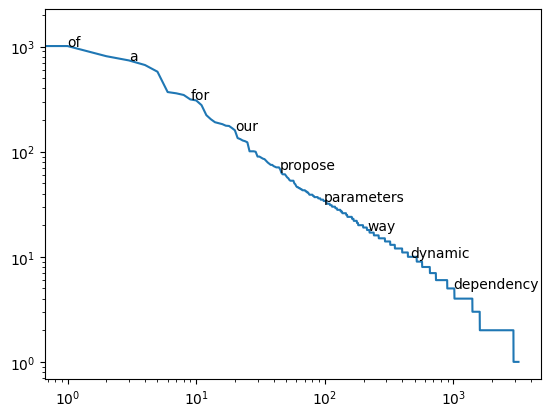

In [47]:
all_counts, all_forms = [], []
for form, count in occurrences.most_common():
    all_counts.append(count)
    all_forms.append(form)
fig,ax = plt.subplots()
ax.plot(all_counts)
ax.set_yscale('log')
ax.set_xscale('log')

for i in torch.logspace(0, torch.log10(torch.tensor(len(all_counts))), 10, dtype=int)-1:
    ax.annotate(all_forms[i], (i, all_counts[i]))

# BPE tokenization
[Byte-Pair Encoding](https://aclanthology.org/P16-1162)

## Pretokenization

To learn BPE we need an initial word vocabulary. For this, use the same code as above but rename `tokenize` in `pretokenize`

In [48]:

class BPETokenizer:
    def __init__(self, V = 1000):
        self.regex = re.compile(r"\w+")
        self.vocabulary = {}
        self.V = V
        self.begin_word = 'Ġ'

    def pretokenize(self, text):
      tokens = re.findall(r"\b\w+\b", text.lower())
      return tokens
      raise NotImplementedError()

    def tokenize(self, text):
        raise NotImplementedError()

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.vocabulary[token] for token in tokens if token in self.vocabulary]
        raise NotImplementedError()

    def set_vocab(self, train_texts):
        raise NotImplementedError()
        occurrences = Counter()

        return occurrences

In [49]:
occurrences = bpe_tokenizer.set_vocab(train_texts)

NameError: name 'bpe_tokenizer' is not defined

In [ ]:
bpe_tokenizer.vocabulary

{'r': 0,
 'e': 1,
 'm': 2,
 'b': 3,
 'i': 4,
 'n': 5,
 'g': 6,
 'a': 7,
 'd': 8,
 'f': 9,
 'o': 10,
 't': 11,
 'c': 12,
 'h': 13,
 's': 14,
 'w': 15,
 'u': 16,
 'l': 17,
 'y': 18,
 'p': 19,
 'v': 20,
 'k': 21,
 'x': 22,
 'j': 23,
 'z': 24,
 '6': 25,
 '0': 26,
 'q': 27,
 '1': 28,
 '8': 29,
 '5': 30,
 '4': 31,
 '9': 32,
 '7': 33,
 'α': 34,
 '3': 35,
 '2': 36,
 'ï': 37,
 'Ġt': 38,
 'in': 39,
 'Ġa': 40,
 'Ġth': 41,
 'on': 42,
 're': 43,
 'ti': 44,
 'er': 45,
 'Ġs': 46,
 'en': 47,
 'Ġthe': 48,
 'Ġo': 49,
 'Ġp': 50,
 'Ġc': 51,
 'or': 52,
 'ing': 53,
 'al': 54,
 'Ġm': 55,
 'at': 56,
 'es': 57,
 'tion': 58,
 'ed': 59,
 'Ġin': 60,
 'is': 61,
 'Ġf': 62,
 'ro': 63,
 'Ġw': 64,
 'Ġd': 65,
 'ar': 66,
 'Ġb': 67,
 'Ġof': 68,
 'an': 69,
 'le': 70,
 'Ġan': 71,
 'it': 72,
 'ic': 73,
 'Ġto': 74,
 'Ġe': 75,
 'et': 76,
 'el': 77,
 'Ġre': 78,
 'ation': 79,
 'ent': 80,
 'as': 81,
 'Ġand': 82,
 'Ġn': 83,
 'ch': 84,
 'us': 85,
 'od': 86,
 'ur': 87,
 'Ġh': 88,
 'om': 89,
 'Ġpro': 90,
 'im': 91,
 'ra': 92,
 'Ġl':

In [ ]:
bpe_tokenizer.merges

[('Ġ', 't'),
 ('i', 'n'),
 ('Ġ', 'a'),
 ('Ġt', 'h'),
 ('o', 'n'),
 ('r', 'e'),
 ('t', 'i'),
 ('e', 'r'),
 ('Ġ', 's'),
 ('e', 'n'),
 ('Ġth', 'e'),
 ('Ġ', 'o'),
 ('Ġ', 'p'),
 ('Ġ', 'c'),
 ('o', 'r'),
 ('in', 'g'),
 ('a', 'l'),
 ('Ġ', 'm'),
 ('a', 't'),
 ('e', 's'),
 ('ti', 'on'),
 ('e', 'd'),
 ('Ġ', 'in'),
 ('i', 's'),
 ('Ġ', 'f'),
 ('r', 'o'),
 ('Ġ', 'w'),
 ('Ġ', 'd'),
 ('a', 'r'),
 ('Ġ', 'b'),
 ('Ġo', 'f'),
 ('a', 'n'),
 ('l', 'e'),
 ('Ġa', 'n'),
 ('i', 't'),
 ('i', 'c'),
 ('Ġt', 'o'),
 ('Ġ', 'e'),
 ('e', 't'),
 ('e', 'l'),
 ('Ġ', 're'),
 ('a', 'tion'),
 ('en', 't'),
 ('a', 's'),
 ('Ġan', 'd'),
 ('Ġ', 'n'),
 ('c', 'h'),
 ('u', 's'),
 ('o', 'd'),
 ('u', 'r'),
 ('Ġ', 'h'),
 ('o', 'm'),
 ('Ġp', 'ro'),
 ('i', 'm'),
 ('r', 'a'),
 ('Ġ', 'l'),
 ('c', 'e'),
 ('Ġ', 'g'),
 ('l', 'y'),
 ('e', 'c'),
 ('v', 'e'),
 ('Ġe', 'x'),
 ('o', 's'),
 ('Ġ', 'on'),
 ('Ġf', 'or'),
 ('Ġw', 'e'),
 ('u', 't'),
 ('u', 'l'),
 ('Ġth', 'at'),
 ('Ġ', 'is'),
 ('u', 'n'),
 ('Ġ', 'le'),
 ('o', 'w'),
 ('p', 'er'),
 ('re', 

In [ ]:
bpe_tokenizer.tokenize(train_texts[0])

['Ġrem',
 'em',
 'ber',
 'ing',
 'Ġand',
 'Ġforgetting',
 'Ġmechanis',
 'ms',
 'Ġare',
 'Ġtwo',
 'Ġs',
 'id',
 'es',
 'Ġof',
 'Ġthe',
 'Ġsame',
 'Ġco',
 'in',
 'Ġin',
 'Ġa',
 'Ġhuman',
 'Ġlearning',
 'Ġm',
 'em',
 'ory',
 'Ġsystem',
 'Ġins',
 'p',
 'ired',
 'Ġby',
 'Ġhuman',
 'Ġb',
 'rain',
 'Ġm',
 'em',
 'ory',
 'Ġmechanis',
 'ms',
 'Ġmod',
 'er',
 'n',
 'Ġmachine',
 'Ġlearning',
 'Ġsystems',
 'Ġhave',
 'Ġbeen',
 'Ġwork',
 'ing',
 'Ġto',
 'Ġend',
 'ow',
 'Ġmachine',
 'Ġwith',
 'Ġl',
 'if',
 'el',
 'ong',
 'Ġlearning',
 'Ġcap',
 'ability',
 'Ġthrough',
 'Ġbetter',
 'Ġrem',
 'em',
 'ber',
 'ing',
 'Ġwhile',
 'Ġp',
 'us',
 'h',
 'ing',
 'Ġthe',
 'Ġforgetting',
 'Ġas',
 'Ġthe',
 'Ġan',
 't',
 'ag',
 'on',
 'ist',
 'Ġto',
 'Ġover',
 'c',
 'ome',
 'Ġne',
 'ver',
 'th',
 'el',
 'ess',
 'Ġthis',
 'Ġid',
 'ea',
 'Ġm',
 'ight',
 'Ġonly',
 'Ġse',
 'e',
 'Ġthe',
 'Ġh',
 'al',
 'f',
 'Ġp',
 'ic',
 't',
 'ure',
 'Ġup',
 'Ġun',
 'til',
 'Ġvery',
 'Ġrec',
 'ently',
 'Ġincreas',
 'ing',
 'Ġresearch',


## Zipf's Law return
Do the same as above with:
- your BPE tokenizer
- the subword tokenizer of [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)





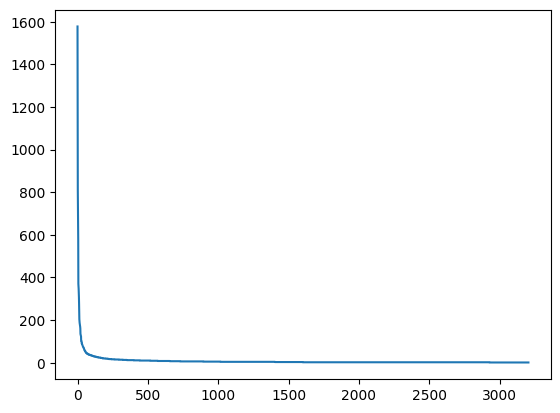

In [ ]:
plt.plot(sorted(occurrences.values(),reverse=True))

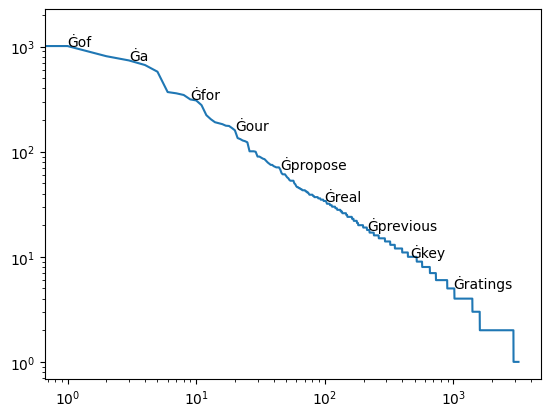

In [ ]:
all_counts, all_forms = [], []
for form, count in occurrences.most_common():
    all_counts.append(count)
    all_forms.append("".join(form))
fig,ax = plt.subplots()
ax.plot(all_counts)
ax.set_yscale('log')
ax.set_xscale('log')

for i in torch.logspace(0, torch.log10(torch.tensor(len(all_counts))), 10, dtype=int)-1:
    ax.annotate(all_forms[i], (i, all_counts[i]))

In [ ]:
gpt_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

In [ ]:
gpt_tokenizer.tokenize(train_texts[0])

['ï',
 '»',
 '¿',
 'Remember',
 'ing',
 'Ġand',
 'Ġforgetting',
 'Ġmechanisms',
 'Ġare',
 'Ġtwo',
 'Ġsides',
 'Ġof',
 'Ġthe',
 'Ġsame',
 'Ġcoin',
 'Ġin',
 'Ġa',
 'Ġhuman',
 'Ġlearning',
 '-',
 'memory',
 'Ġsystem',
 '.',
 'ĠInspired',
 'Ġby',
 'Ġhuman',
 'Ġbrain',
 'Ġmemory',
 'Ġmechanisms',
 ',',
 'Ġmodern',
 'Ġmachine',
 'Ġlearning',
 'Ġsystems',
 'Ġhave',
 'Ġbeen',
 'Ġworking',
 'Ġto',
 'Ġend',
 'ow',
 'Ġmachine',
 'Ġwith',
 'Ġlifelong',
 'Ġlearning',
 'Ġcapability',
 'Ġthrough',
 'Ġbetter',
 'Ġremembering',
 'Ġwhile',
 'Ġpushing',
 'Ġthe',
 'Ġforgetting',
 'Ġas',
 'Ġthe',
 'Ġantagonist',
 'Ġto',
 'Ġovercome',
 '.',
 'ĠNevertheless',
 ',',
 'Ġthis',
 'Ġidea',
 'Ġmight',
 'Ġonly',
 'Ġsee',
 'Ġthe',
 'Ġhalf',
 'Ġpicture',
 '.',
 'ĠUp',
 'Ġuntil',
 'Ġvery',
 'Ġrecently',
 ',',
 'Ġincreasing',
 'Ġresearchers',
 'Ġargue',
 'Ġthat',
 'Ġa',
 'Ġbrain',
 'Ġis',
 'Ġborn',
 'Ġto',
 'Ġforget',
 ',',
 'Ġi',
 '.',
 'e',
 '.,',
 'Ġforgetting',
 'Ġis',
 'Ġa',
 'Ġnatural',
 'Ġand',
 'Ġactive',
 'Ġpr

In [ ]:
gpt_tokenizer(train_texts[:4])['input_ids']

[[171,
  119,
  123,
  16676,
  278,
  290,
  32012,
  11701,
  389,
  734,
  5389,
  286,
  262,
  976,
  10752,
  287,
  257,
  1692,
  4673,
  12,
  31673,
  1080,
  13,
  45827,
  416,
  1692,
  3632,
  4088,
  11701,
  11,
  3660,
  4572,
  4673,
  3341,
  423,
  587,
  1762,
  284,
  886,
  322,
  4572,
  351,
  25837,
  4673,
  12971,
  832,
  1365,
  24865,
  981,
  7796,
  262,
  32012,
  355,
  262,
  34667,
  284,
  10980,
  13,
  15933,
  11,
  428,
  2126,
  1244,
  691,
  766,
  262,
  2063,
  4286,
  13,
  3205,
  1566,
  845,
  2904,
  11,
  3649,
  4837,
  7267,
  326,
  257,
  3632,
  318,
  4642,
  284,
  6044,
  11,
  1312,
  13,
  68,
  1539,
  32012,
  318,
  257,
  3288,
  290,
  4075,
  1429,
  329,
  12531,
  11,
  5527,
  11,
  290,
  12846,
  24612,
  13,
  770,
  3348,
  10969,
  220,
  281,
  13936,
  286,
  17019,
  4572,
  4673,
  4981,
  326,
  779,
  257,
  4088,
  2746,
  284,
  2193,
  290,
  6044,
  13,
  383,
  4075,
  32012,
  9030,
  357,
  8579,


In [ ]:
vocab = tokenizer.vocab

In [ ]:
len(vocab)

50257

In [ ]:
vocab["the"]

1169

In [ ]:
i2token = {i: token for token, i in vocab.items()}
assert len(i2token) == len(vocab)

In [ ]:
tokens = gpt_tokenizer(train_texts)['input_ids']

In [ ]:
occurrences = Counter()
for token in tokens:
    occurrences += Counter(token)

In [ ]:
len(occurrences)

3911

In [ ]:
for index, count in occurrences.most_common(10):
    print(i2token[index], index, count)

Ġthe 262 1429
, 11 1204
. 13 1170
- 12 1103
Ġof 286 980
Ġto 284 758
Ġa 257 723
Ġand 290 656
Ġin 287 450
Ġthat 326 370


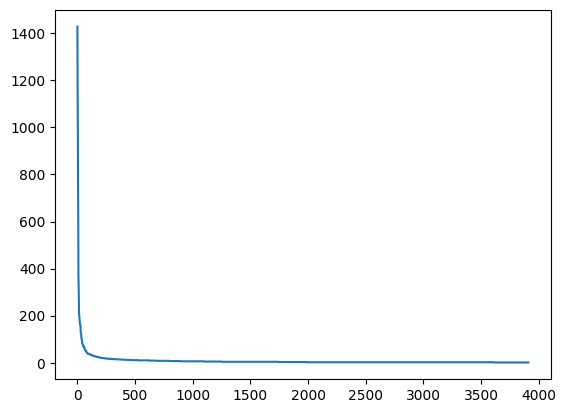

In [ ]:
plt.plot(sorted(occurrences.values(),reverse=True))

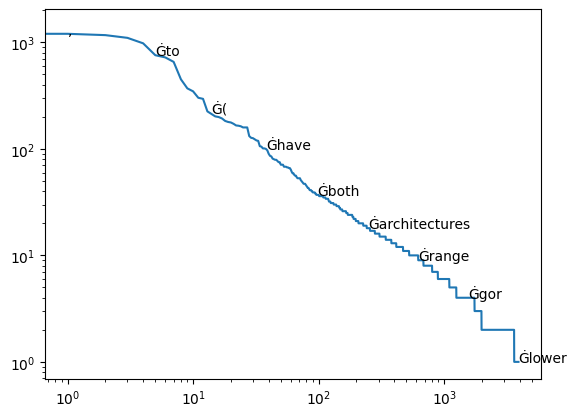

In [ ]:
all_counts = torch.tensor(list(occurrences.values()))
i = (-all_counts).argsort()
all_counts=all_counts[i]
all_forms = list(occurrences.keys())
all_forms = [i2token[all_forms[j.item()]] for j in i]
fig,ax = plt.subplots()
ax.plot(all_counts)
ax.set_yscale('log')
ax.set_xscale('log')

for i in torch.logspace(0, torch.log10(torch.tensor(len(all_counts))), 10).int()-1: #decile_eg(all_counts):
    ax.annotate(all_forms[i], (i, all_counts[i]))

# Naive Bayes

In [ ]:
class NaiveBayes:
    def __init__(self, V, num_labels):
        self.V = V
        self.num_labels = num_labels
        self.log_priors = torch.zeros(self.num_labels)
        self.log_posteriors = torch.zeros(self.num_labels, self.V)

    def fit(self, train_bow, train_labels):
        raise NotImplementedError()

    def predict(self, bow):
        raise NotImplementedError()

In [ ]:
model = NaiveBayes(len(tokenizer.vocabulary), len(train_labels.unique()))

model.fit(train_bow, train_labels)

preds = model.predict(test_bow)

(preds == test_labels).float().mean()

tensor(0.6500)

# Bonus

Have a look at `sklearn` [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) combined with [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), what other parameters haven't we discussed in class? See also [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html).

What about [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)? How do you think it could be useful?

You can also try other `sklearn` classifiers using the bag-of-words representation